In [1]:
import pandas as pd
# pd.set_option("display.max_colwidth", 200)
import numpy as np
import json
import re
import gzip
import spacy

import gensim
from gensim import corpora
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\tanma\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
from nltk.corpus import stopwords

import nltk

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer

from nltk.stem import WordNetLemmatizer

from tqdm import tqdm

In [3]:
review_df = pd.read_csv('./data/reviews.csv')
review_df.drop(columns=['Unnamed: 0'], inplace= True)

review_df['user_id'].nunique()

review_df['review_text'].fillna('', inplace = True)

In [4]:
review_df.head()

engaged_df = review_df[(review_df['n_votes'] > 0)|(review_df['n_comments'] > 0)]

engaged_df.head()

,book_id,user_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
6,5805,4cbecbc15af3db041a8e0f594c642bb5,58f2301bd2d4bbfc1b51e4e5fb161cfe,5,"Remember, remember, the fifth of November. Thi...",Wed Jun 13 17:55:53 -0700 2012,Mon Jan 30 05:58:01 -0800 2017,Thu Jun 14 00:00:00 -0700 2012,NaN,7,0
8,5805,49cc59f1c479d698507627b401d47ecf,761a17f52538341a085b629a316204a1,4,Tinha apontado este livro como um dos que tinh...,Sun Jan 05 03:27:10 -0800 2014,Tue Oct 28 15:58:20 -0700 2014,Tue Oct 28 15:58:20 -0700 2014,NaN,1,0
10,5805,5f03864c758bfceb6d7d5e93eeb20044,ac54c3ce0c9f660c03881b0668f79c60,5,Review coming soon! www.youtube.com/ReadTomes,Tue Feb 12 11:38:36 -0800 2013,Tue Feb 12 12:00:47 -0800 2013,Tue Feb 12 12:00:47 -0800 2013,Tue Feb 12 00:00:00 -0800 2013,1,0
12,5805,c309dff1695ed8558b29ea8dcd7479b8,0da0bcc469c2acd15350f9a8f0a74e2b,5,"What better way to celebrate Guy Fawkes Day, t...",Tue May 20 09:52:36 -0700 2014,Thu Mar 16 09:49:11 -0700 2017,Wed Nov 05 14:22:10 -0800 2014,Wed Nov 05 00:00:00 -0800 2014,2,0
13,5805,0f6b8c04f811e05c8978bd6b66ce7685,7d670b6c8cac0c086e21ae2f1af6eccb,4,To note - I am writing this review a quarter c...,Tue Jul 03 16:43:26 -0700 2012,Fri Feb 27 14:46:00 -0800 2015,Tue Jan 01 00:00:00 -0800 1991,NaN,10,0


In [15]:
lm  = WordNetLemmatizer()

# nlp = spacy.load('en', disable=['parser', 'ner'])
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])



In [16]:
stop_words = set(stopwords.words('english'))

words = set(nltk.corpus.words.words())

In [17]:
def preprocess(x):
    try:
        x = re.sub("n\'t", " not", x)
        x = re.sub("\'d", " would", x)
        x = re.sub("[^a-zA-Z0-9#]", " ", x)
        x = re.sub("www", " ", x)
        x = re.sub("http", " ", x)
        x = re.sub("https", " ", x)
        x = re.sub("com", " ", x)
        x = re.sub("url", " ", x)
        return x
    except:
        print(x)
        return ""
    

def lemmas(x, lm, tags=['NOUN', 'ADJ']):
    x = word_tokenize(x)
    
    x = [lm.lemmatize(w).lower() for w in x]
    
#     print(x)
    x = nlp(" ".join(x))
#     x = [w for w in x if w in words]
    x = [token.lemma_ for token in x if token.pos_ in tags or token.lemma_ in words]
    x = [w for w in x if not w.lower() in stop_words]
    x = [w for w in x if len(w) > 2]
    
    return x

In [18]:
engaged_df['clean_reviews'] = engaged_df['review_text'].apply(lambda x: preprocess(x))



C:\Users\tanma\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
%%time
engaged_df['clean_reviews'] = engaged_df['clean_reviews'].apply(lambda x: lemmas(x, lm))

Wall time: 4min 23s


C:\Users\tanma\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [42]:
dictionary = corpora.Dictionary(engaged_df['clean_reviews'])

doc_term_matrix = [dictionary.doc2bow(rev) for rev in engaged_df['clean_reviews']]

In [43]:
doc_term_matrix

[[(0, 1),
  (1, 1),
  (2, 5),
  (3, 2),
  (4, 1),
  (5, 2),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 2),
  (29, 5),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 2),
  (39, 4),
  (40, 2),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 4),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 2),
  (52, 1),
  (53, 1),
  (54, 2),
  (55, 1),
  (56, 1),
  (57, 2),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 2),
  (67, 2),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 3),
  (72, 2),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 2),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 3),
  (81, 1),
  (82, 1),
  (83, 2),
  (84, 2),
  (85, 1),
  (86, 1),
  (87, 2),
  (88, 1),
  (89, 2),
  (90, 1),
  (91, 1)

In [24]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=1):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, stop, step)):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [25]:
model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix, engaged_df['clean_reviews'], 12)


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

  0%|                                                                            | 1/39787 [00:38<429:17:43, 38.84s/it]

100%|███████████████████████████████████████████████████████████████████████████| 39787/39787 [00:41<00:00, 970.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:31<00:00, 21.14s/it]


In [26]:
model_list

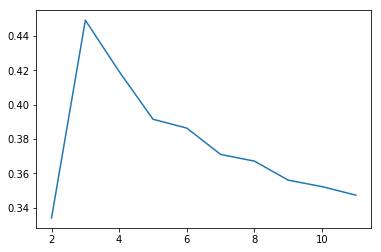

In [28]:
plt.plot(range(2,12,1), coherence_values)

### Training the best model

In [44]:
%%time
lsi = LsiModel(doc_term_matrix, num_topics=3, id2word = dictionary)

Wall time: 4.36 s


In [45]:
lsi.show_topics()

[(0,
  '0.309*"story" + 0.280*"book" + 0.239*"like" + 0.239*"read" + 0.218*"one" + 0.194*"character" + 0.171*"get" + 0.150*"really" + 0.145*"make" + 0.139*"love"'),
 (1,
  '0.760*"book" + -0.348*"volume" + -0.242*"story" + 0.233*"read" + -0.202*"character" + -0.151*"series" + 0.109*"novel" + 0.103*"graphic" + -0.087*"get" + -0.068*"love"'),
 (2,
  '0.679*"batman" + 0.481*"story" + -0.232*"volume" + 0.171*"joker" + -0.150*"like" + -0.141*"love" + -0.135*"series" + -0.114*"read" + -0.109*"get" + 0.105*"dark"')]

In [46]:
%%time
lsi = LsiModel(doc_term_matrix, num_topics=4, id2word = dictionary)

Wall time: 4.38 s


In [47]:
lsi.show_topics()

[(0,
  '0.309*"story" + 0.280*"book" + 0.239*"like" + 0.239*"read" + 0.218*"one" + 0.194*"character" + 0.171*"get" + 0.150*"really" + 0.145*"make" + 0.139*"love"'),
 (1,
  '0.759*"book" + -0.359*"volume" + 0.228*"read" + -0.222*"story" + -0.207*"character" + -0.159*"series" + 0.107*"novel" + 0.101*"graphic" + -0.091*"get" + -0.075*"love"'),
 (2,
  '0.683*"batman" + 0.489*"story" + -0.214*"volume" + 0.172*"joker" + -0.144*"like" + -0.135*"love" + -0.135*"series" + -0.121*"read" + 0.103*"dark" + -0.102*"get"'),
 (3,
  '-0.585*"story" + 0.312*"batman" + -0.308*"novel" + -0.283*"graphic" + 0.270*"like" + -0.246*"read" + 0.143*"get" + -0.143*"love" + 0.110*"one" + 0.093*"thing"')]

In [39]:
lsi.show_topic(2)

[('batman', 0.6834286497875538),
 ('story', 0.48874548881269286),
 ('volume', -0.21366421913171688),
 ('joker', 0.17244798066670558),
 ('like', -0.1441299361331999),
 ('love', -0.13508424491198076),
 ('series', -0.13465694842571202),
 ('read', -0.12084476074894476),
 ('dark', 0.10281629069118543),
 ('get', -0.10224740841161464)]